# Comparison of PPCA with sklearn PCA

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np
import time

from sklearn.decomposition import PCA as PCA_sklearn
from sklearn.datasets import load_iris

from scipy.linalg import subspace_angles

from ppca import PPCA

np.random.seed(1)

## Complete data case

Let's first look at a comparison in the case when the data is complete (no missing values). From plotting the transformed values of both the sklearn PCA and our implementation of PPCA we can observe that up to the scale they are almost identical.

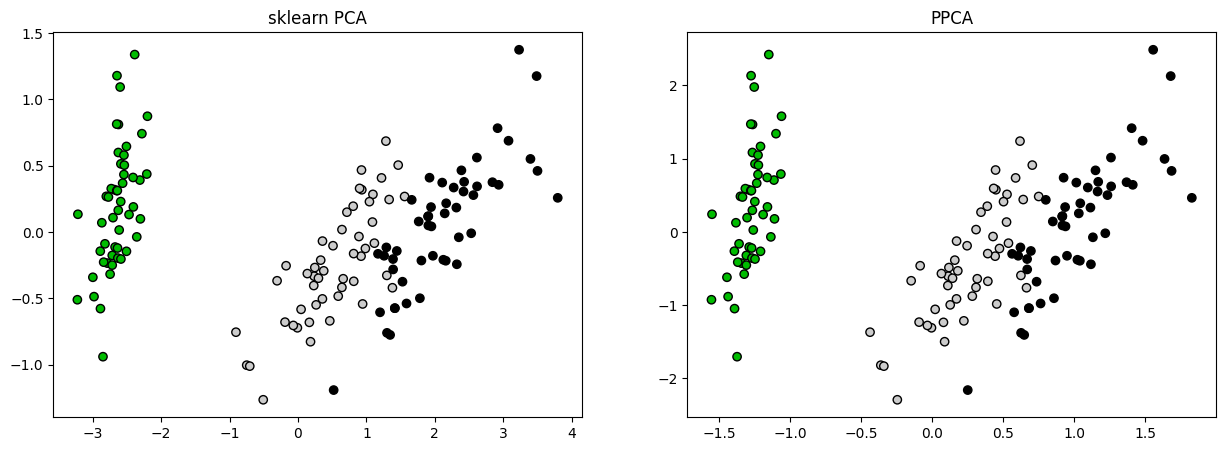

In [2]:
iris = load_iris()
X = iris.data
y = iris.target
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)

pca_sklearn = PCA_sklearn(n_components=2)
Z_sklearn = pca_sklearn.fit_transform(X)

ppca = PPCA(n_components=2)
Z = ppca.fit_transform(X)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

Zs = [Z_sklearn, Z]
titles = ["sklearn PCA", "PPCA"]

for i, (data, title) in enumerate(zip(Zs, titles)):
    ax[i].scatter(data[:, 0], data[:, 1], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")
    ax[i].set_title(title)

plt.show()

To quantify the dissimilarity of the principle component subspaces learned by the two implementations, we can compute their angle. Indeed the angle is tiny, meaning that the learned principle subspaces are identical:

In [3]:
print("Angle between subspaces: {}".format(np.rad2deg(subspace_angles(pca_sklearn.components_.T, ppca.W_.T)[0])))

Angle between subspaces: 9.85563974280865e-13


Finally, we can look at some of the attributes and compare them. Even though they are very similar, there are small differences. E.g., in scikit-learn, explained_variance is computed based on (n_samples - 1) degrees of freedom, whereas this implementation simply assumes n_samples degrees of freedom.

In [4]:
print("{0: >30} {1: >40} {2: >40}".format("Attribute", "sklearn PCA", "PPCA"))
strfmt = "{0: >30} {1: >40} {2: >40}"
print(strfmt.format("explained_variance_", np.array2string(pca_sklearn.explained_variance_), np.array2string(ppca.explained_variance_)))
print(strfmt.format("explained_variance_ratio_", np.array2string(pca_sklearn.explained_variance_ratio_), np.array2string(ppca.explained_variance_ratio_)))
print(strfmt.format("noise_variance_", np.array2string(pca_sklearn.noise_variance_), np.array2string(ppca.noise_variance_)))

                     Attribute                              sklearn PCA                                     PPCA
           explained_variance_                  [4.22824171 0.24267075]                  [4.26241451 0.2410533 ]
     explained_variance_ratio_                  [0.92461872 0.05306648]                  [0.92564139 0.05234801]
               noise_variance_                                0.0510223                               0.05067745


Note that in PPCA, the principle axes, given by W, are scaled by the noise-adjusted variances (see e.g. Bishop [1]). However, we can compare the normalized values.

In [5]:
print("sklearn PCA components:")
print(pca_sklearn.components_)

print("normalized PPCA components:")
print(ppca.W_ / np.linalg.norm(ppca.W_, axis=1, keepdims=True))

sklearn PCA components:
[[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]
normalized PPCA components:
[[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]


## Missing data case

We now move on to the case when some observations have missing values. Note that sklearn PCA cannot be run with missing values. But we can run it on the complete data to use it as a benchmark.

To illustrate that PPCA is a probabilistic model, we can also plot the covariances through ellipses, which correspond to contours having one standard deviation.

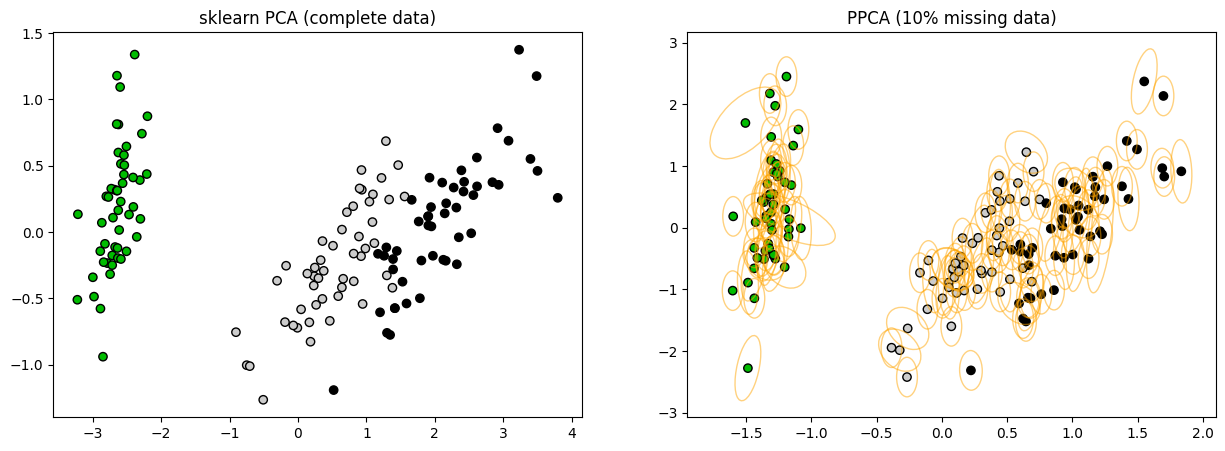

In [6]:
def draw_ellipse(ax, cov, mean):
    pearson = cov[:, 0, 1]/np.sqrt(cov[:, 0, 0] * cov[:, 1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    for i in range(len(cov)):
        ellipse = Ellipse((0,0), width=ell_radius_x[i] * 2, height=ell_radius_y[i] * 2, facecolor='none', edgecolor='orange', alpha=0.5)
        scale_x = np.sqrt(cov[i, 0, 0]) * 1
        scale_y = np.sqrt(cov[i, 1, 1]) * 1
        mean_x = mean[i, 0]
        mean_y = mean[i, 1]
        transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        ax.add_patch(ellipse)


# Remove 10% of the data randomly
missing = np.random.uniform(size=X.shape) < 0.1
X_missing = X.copy()
X_missing[missing] = np.nan

ppca = PPCA(n_components=3)
Z, covZ = ppca.fit_transform(X_missing, return_cov=True)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(Z_sklearn[:, 0], Z_sklearn[:, 1], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")
ax[0].set_title("sklearn PCA (complete data)")

ax[1].scatter(Z[:, 0], Z[:, 1], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")
draw_ellipse(ax[1], covZ, Z)
ax[1].set_title("PPCA (10% missing data)")

plt.show()

Qualitatively, the transformed values look similar at 10% missingness. To get a better idea, we can plot the angle of the subspaces to the complete sklearn PCA as a function of the missingness percentage.

Execution time: 34.156237840652466 seconds


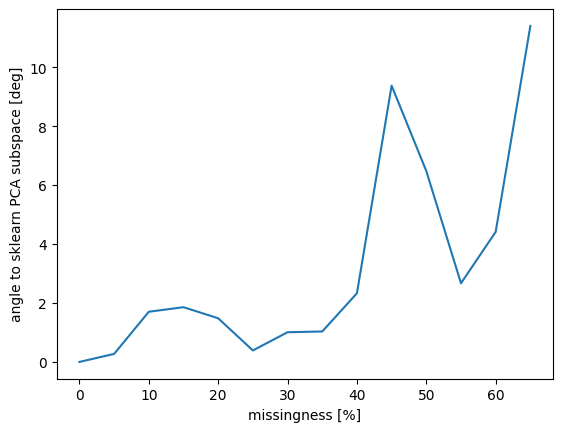

In [7]:
missingness = np.linspace(0, 0.7, 14, endpoint=False)

start_t = time.time()

angles = []
for m in missingness:
    # Remove m% of the data randomly
    missing = np.random.uniform(size=X.shape) < m
    X_missing = X.copy()
    X_missing[missing] = np.nan
    # Remove observations which have all nans...
    all_missing = np.all(np.isnan(X_missing), axis=1)
    X_missing = X_missing[~all_missing, :]

    ppca = PPCA(n_components=3)
    Z = ppca.fit_transform(X_missing)
    angles.append(np.rad2deg(subspace_angles(pca_sklearn.components_.T, ppca.W_.T)[0]))

end_t = time.time()

print("Execution time: {} seconds".format(end_t - start_t))

plt.figure()
plt.plot(missingness * 100, angles)
plt.xlabel("missingness [%]")
plt.ylabel("angle to sklearn PCA subspace [deg]")
plt.show()

We can also use the PPCA model to reconstruct some data (here from 10% missingness) and compare it to the original dataset:

In [8]:
# Remove 10% of the data randomly
missing = np.random.uniform(size=X.shape) < 0.1
X_missing = X.copy()
X_missing[missing] = np.nan

ppca = PPCA(n_components=2)
Z = ppca.fit_transform(X_missing)

X_hat = ppca.reconstruct(Z)
print(f"residual root mean square error: {np.sqrt(np.nanmean((X_missing - X_hat) ** 2)):.6f}")

residual root mean square error: 0.159173


PPCA reconstructions are not ideal in the squared residual error sense, because the projection is not orthogonal due to the noise. We can construct an orthogonal reconstruction for the noisy model, which should have a lower RMSE.

In [9]:
X_hat = ppca.reconstruct(Z, orthogonal=True)
print(f"residual root mean square error: {np.sqrt(np.nanmean((X_missing - X_hat) ** 2)):.6f}")

residual root mean square error: 0.150262


Finally, we can evaluate the data log likelihood, either for individual observations, or the overall dataset.

data log likelihood: -391.70486792263546


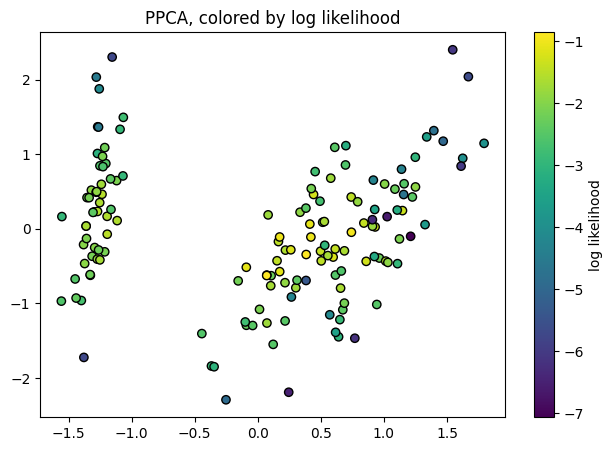

In [10]:
print(f"data log likelihood: {ppca.log_likelihood(X_missing)}")

ll = ppca.log_likelihood(X_missing, reduction='none')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

im = ax.scatter(Z[:, 0], Z[:, 1], c=ll, edgecolor="k")
ax.set_title("PPCA, colored by log likelihood")
cbar = fig.colorbar(im)
cbar.set_label("log likelihood")

plt.show()